# analyze binclf speed test

Test which variation of FPR computation is faster.

# setup

In [1]:
from __future__ import annotations

In [2]:
# make a cell print all the outputs instead of just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# adjust the number of significant digits 
import pandas as pd
pd.set_option('display.precision', 5)

# load

In [44]:
from pathlib import Path
LOAD_DIR = Path("./.cache/binclf-speed-test")
assert LOAD_DIR.exists()

from pathlib import Path
csv_fpaths = sorted(LOAD_DIR.glob('*.csv'))
print(f"{len(csv_fpaths)} csv files found")

import pandas as pd
df = pd.concat([pd.read_csv(fpath) for fpath in csv_fpaths], ignore_index=True, axis=0, sort=False)
df["mode"] = df["mode"].fillna("perimg")
df.head()
df.shape

2850 csv files found


,resolution,num_images,num_thresholds,seed,algorithm,device,hostname,num_cpus,seconds,mode
0,1024,100,100000,0,numpy_itertools,cpu,node042,32,52.49109,perimg
1,1024,100,100000,0,numpy_itertools,cpu,node042,32,52.67332,perimg
2,1024,100,100000,0,numpy_itertools,cpu,node042,32,52.63801,perimg
3,1024,100,100000,0,numpy_itertools,cpu,node042,32,52.68699,perimg
4,1024,100,100000,0,numpy_itertools,cpu,node042,32,54.19016,perimg


(14250, 10)

In [29]:
df_perimg = df.query('mode == "perimg"')
df_perimg = df_perimg.drop(columns=["mode"]).reset_index(drop=True)
df_perimg["imgs_persec"] = df_perimg["num_images"] / df_perimg["seconds"]
df_perimg.head()
df_perimg.shape

,resolution,num_images,num_thresholds,seed,algorithm,device,hostname,num_cpus,seconds,imgs_persec
0,1024,100,100000,0,numpy_itertools,cpu,node042,32,52.49109,1.90509
1,1024,100,100000,0,numpy_itertools,cpu,node042,32,52.67332,1.89849
2,1024,100,100000,0,numpy_itertools,cpu,node042,32,52.63801,1.89977
3,1024,100,100000,0,numpy_itertools,cpu,node042,32,52.68699,1.89800
4,1024,100,100000,0,numpy_itertools,cpu,node042,32,54.19016,1.84535


(12120, 10)

In [30]:
df_set = df.query('mode == "set"')
df_set = df_set.drop(columns=["mode"]).reset_index(drop=True)
df_set["num_samples"] = df_set["num_images"] * ( df_set["resolution"] ** 2 )
df_set["thousand_samples"] = df_set["num_samples"] / 1000
df_set["thousand_samples_persec"] = df_set["thousand_samples"] / df_perimg["seconds"]
df_set.head()
df_set.shape

,resolution,num_images,num_thresholds,seed,algorithm,device,hostname,num_cpus,seconds,num_samples,thousand_samples,thousand_samples_persec
0,128,100,100000,0,numpy_itertools,cpu,node043,32,0.65877,1638400,1638.4,31.21291
1,128,100,100000,0,numpy_itertools,cpu,node043,32,0.65452,1638400,1638.4,31.10493
2,128,100,100000,0,numpy_itertools,cpu,node043,32,0.65242,1638400,1638.4,31.12580
3,128,100,100000,0,numpy_itertools,cpu,node043,32,0.65201,1638400,1638.4,31.09686
4,128,100,100000,0,numpy_itertools,cpu,node043,32,0.65534,1638400,1638.4,30.23427


(2130, 12)

In [31]:
del df 

# experiment 1 (perimg): all algorithms

On each plot:
    - x-axis: `num_thrsholds`
    - y-axis: `imgs_persec`
    - each line is a different (`algorithm`, `device`)
    - `device == 'cuda'` is in dashed line

Subplots:
    - column: `resolution`
    - row: `num_images`

/tmp/ipykernel_631819/1422739862.py:67: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  for ax, (ridx, cidx) in zip(axes.flatten(), np.ndindex(axes.shape)): _ = ax.set_ylim(pgrows_lims[ridx][1])
/tmp/ipykernel_631819/1422739862.py:69: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  for ax, (ridx, cidx) in zip(axes.flatten(), np.ndindex(axes.shape)): _ = ax.set_xlim(pgcols_lims[cidx][0])


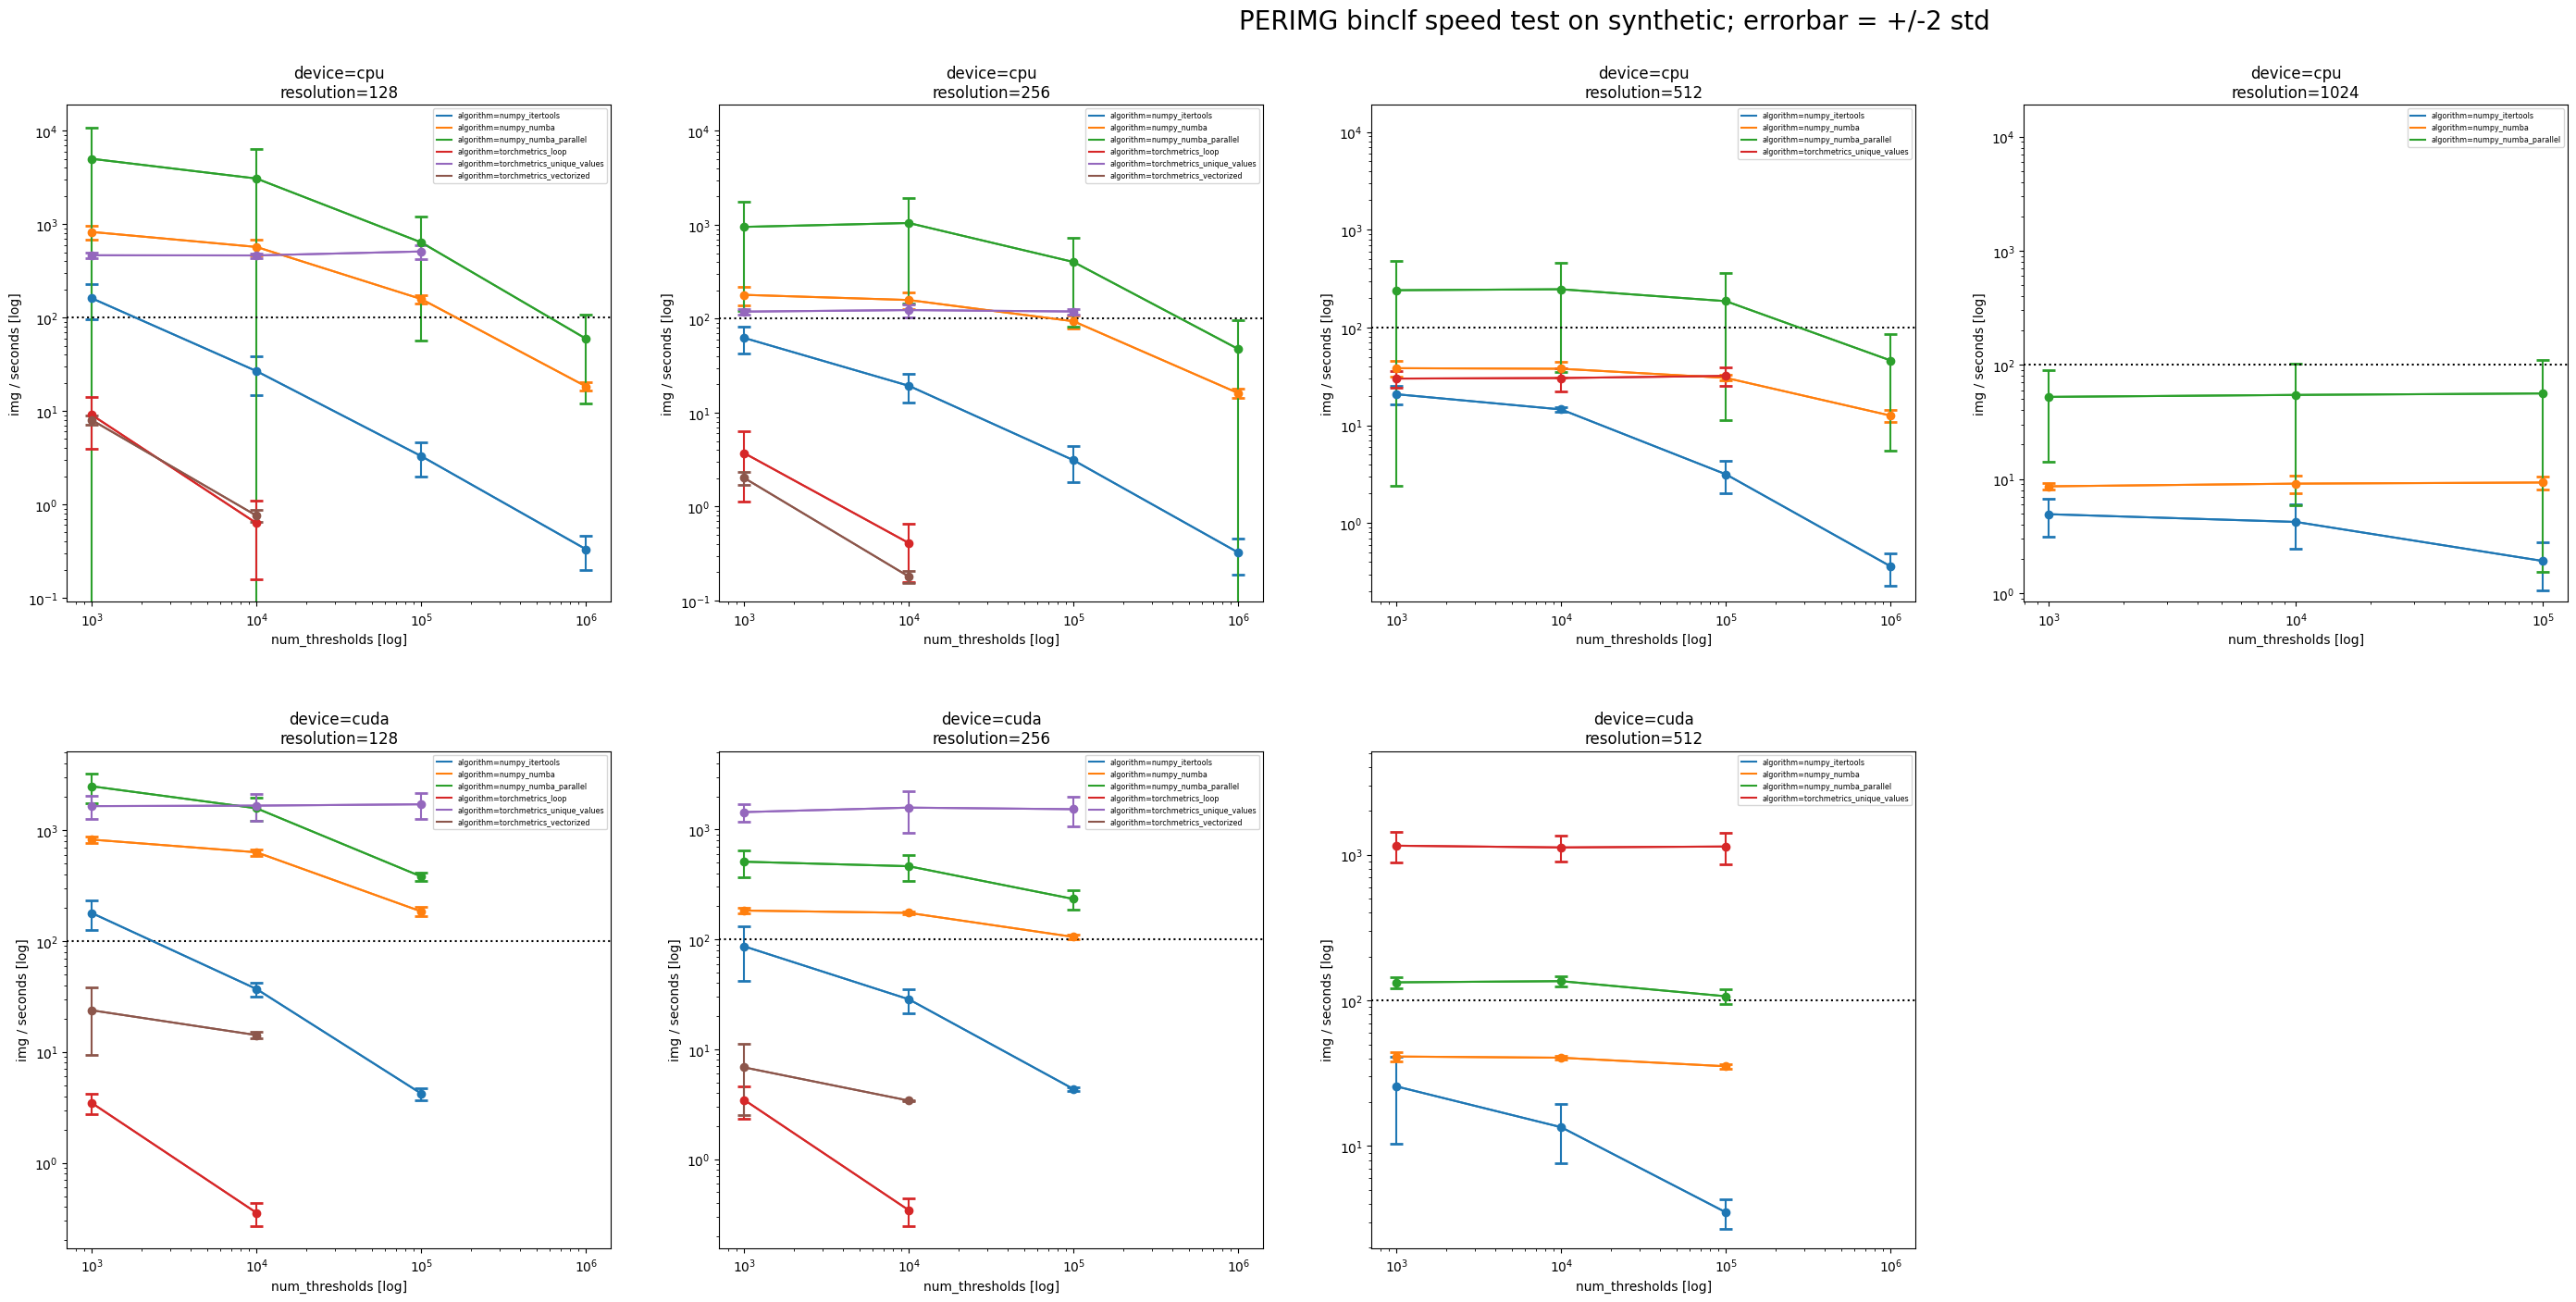

In [25]:
import numpy as np
from matplotlib import pyplot as plt

PLOTGRID_ROW_COLS = ["device"]
PLOTGRID_COL_COLS = ["resolution"]
LINE_COLS = ["algorithm", ]

dfplot = df_perimg.query("num_images in (200,) ")

# `pg` stands for `plotgrid`
pg_row_dfidxs = dfplot.groupby(PLOTGRID_ROW_COLS).size().index.tolist() if len(PLOTGRID_ROW_COLS) > 0 else [None]
pg_col_dfidxs = dfplot.groupby(PLOTGRID_COL_COLS).size().index.tolist() if len(PLOTGRID_COL_COLS) > 0 else [None]

fig, axes = plt.subplots(nr := len(pg_row_dfidxs), nc := len(pg_col_dfidxs) + 1, figsize=(nc * (sz := 7), nr * sz))
axes = (axes if nr*nc > 1 else np.array(axes) ).reshape(nr, nc) 

# `gidx` stands for `group index` , `gdf` stands for `group dataframe`
for pgrow_gidx, pgrow_gdf in dfplot.groupby(PLOTGRID_ROW_COLS) if len(PLOTGRID_ROW_COLS) > 0 else [((None,), dfplot)]:
    for pgcol_gidx, pgcol_gdf in pgrow_gdf.groupby(PLOTGRID_COL_COLS) if len(PLOTGRID_COL_COLS) > 0 else [((None,), pgrow_gdf)]:
        if len(pgcol_gdf) == 0: continue
        
        # convert dataframe index (tuple[any]) into int index of the plotgrid rows and columns 
        # it has to be converted like this because some `pgrow_df` may not have all the column groups
        # `ridx`/`cidx` stands for `row-index`/`col-index`
        pg_ridx = pg_row_dfidxs.index(pgrow_gidx[0] if len(pgrow_gidx) == 1 else pgrow_gidx)  
        pg_cidx = pg_col_dfidxs.index(pgcol_gidx[0] if len(pgcol_gidx) == 1 else pgcol_gidx)  
        ax = axes[pg_ridx, pg_cidx]
        
        # `rname`/`cname` stands for `row-name`/`col-name`
        pg_rname = ", ".join(map("=".join, zip(PLOTGRID_ROW_COLS, map(str, pgrow_gidx)))) if pgrow_gidx[0] is not None else ""
        pg_cname = ", ".join(map("=".join, zip(PLOTGRID_COL_COLS, map(str, pgcol_gidx)))) if pgcol_gidx[0] is not None else ""
        _ = ax.set_title(f"{pg_rname}\n{pg_cname}".strip())
        
        for line_gidx, line_gdf in pgcol_gdf.groupby(LINE_COLS) if len(LINE_COLS) > 0 else [((None,), pgcol_gdf)]:
            if len(line_gdf) == 0: continue
            
            # `lname` stands for `line-name`
            pg_lname = ", ".join(map("=".join, zip(LINE_COLS, map(str, line_gidx)))) if line_gidx is not None else ""

            # ------------------------------------------------------------
            data = line_gdf.groupby("num_thresholds").describe()["imgs_persec"][["mean", "std", "count"]].reset_index()
            xs = data["num_thresholds"]
            ys = data["mean"]
            yerr = data["std"] * 2
            line_handle = ax.plot(xs, ys, label=pg_lname, linestyle="-")[0]
            if not np.isnan(yerr).any():
                _ = ax.errorbar(
                    xs, ys, yerr=yerr, 
                    fmt='o', capsize=5, capthick=2, 
                    ecolor=line_handle.get_color(), color=line_handle.get_color(), linestyle=line_handle.get_linestyle()
                )
        
        _ = ax.axhline(100, color='k', linestyle=":")    
        
        _ = ax.set_xscale("log")
        _ = ax.set_yscale("log")
        _ = ax.set_xlabel("num_thresholds [log]")
        _ = ax.set_ylabel("img / seconds [log]")
        _ = ax.legend(loc='upper right', fontsize='xx-small')
        

lims = np.array([[ax.get_xlim(), ax.get_ylim()] for ax in axes.flatten()]).reshape(axes.shape + (2, 2))
pgrows_lims = np.stack([lims[..., 0].min(axis=1), lims[..., 1].max(axis=1)], axis=-1)
pgcols_lims = np.stack([lims[..., 0].min(axis=0), lims[..., 1].max(axis=0)], axis=-1)

# grid-row: same y-axis limits
for ax, (ridx, cidx) in zip(axes.flatten(), np.ndindex(axes.shape)): _ = ax.set_ylim(pgrows_lims[ridx][1])
# grid-col: same x-axis limits
for ax, (ridx, cidx) in zip(axes.flatten(), np.ndindex(axes.shape)): _ = ax.set_xlim(pgcols_lims[cidx][0])

# turn off axes for subplots that are empty    
for ax in [ax for ax in axes.flatten() if not ax.get_title()]: _ = ax.set_visible(False)

_ = fig.suptitle("PERIMG binclf speed test on synthetic; errorbar = +/-2 std", fontsize=20, y=1.002)
_ = fig.tight_layout(h_pad=0, w_pad=0)
_ = fig.subplots_adjust(hspace=0.3, wspace=0.2)

# experiment 1 (perimg): numba vs numba parallel

On each plot:
    - x-axis: ``
    - y-axis: ``

Subplots:
    - column: ``
    - row: ``

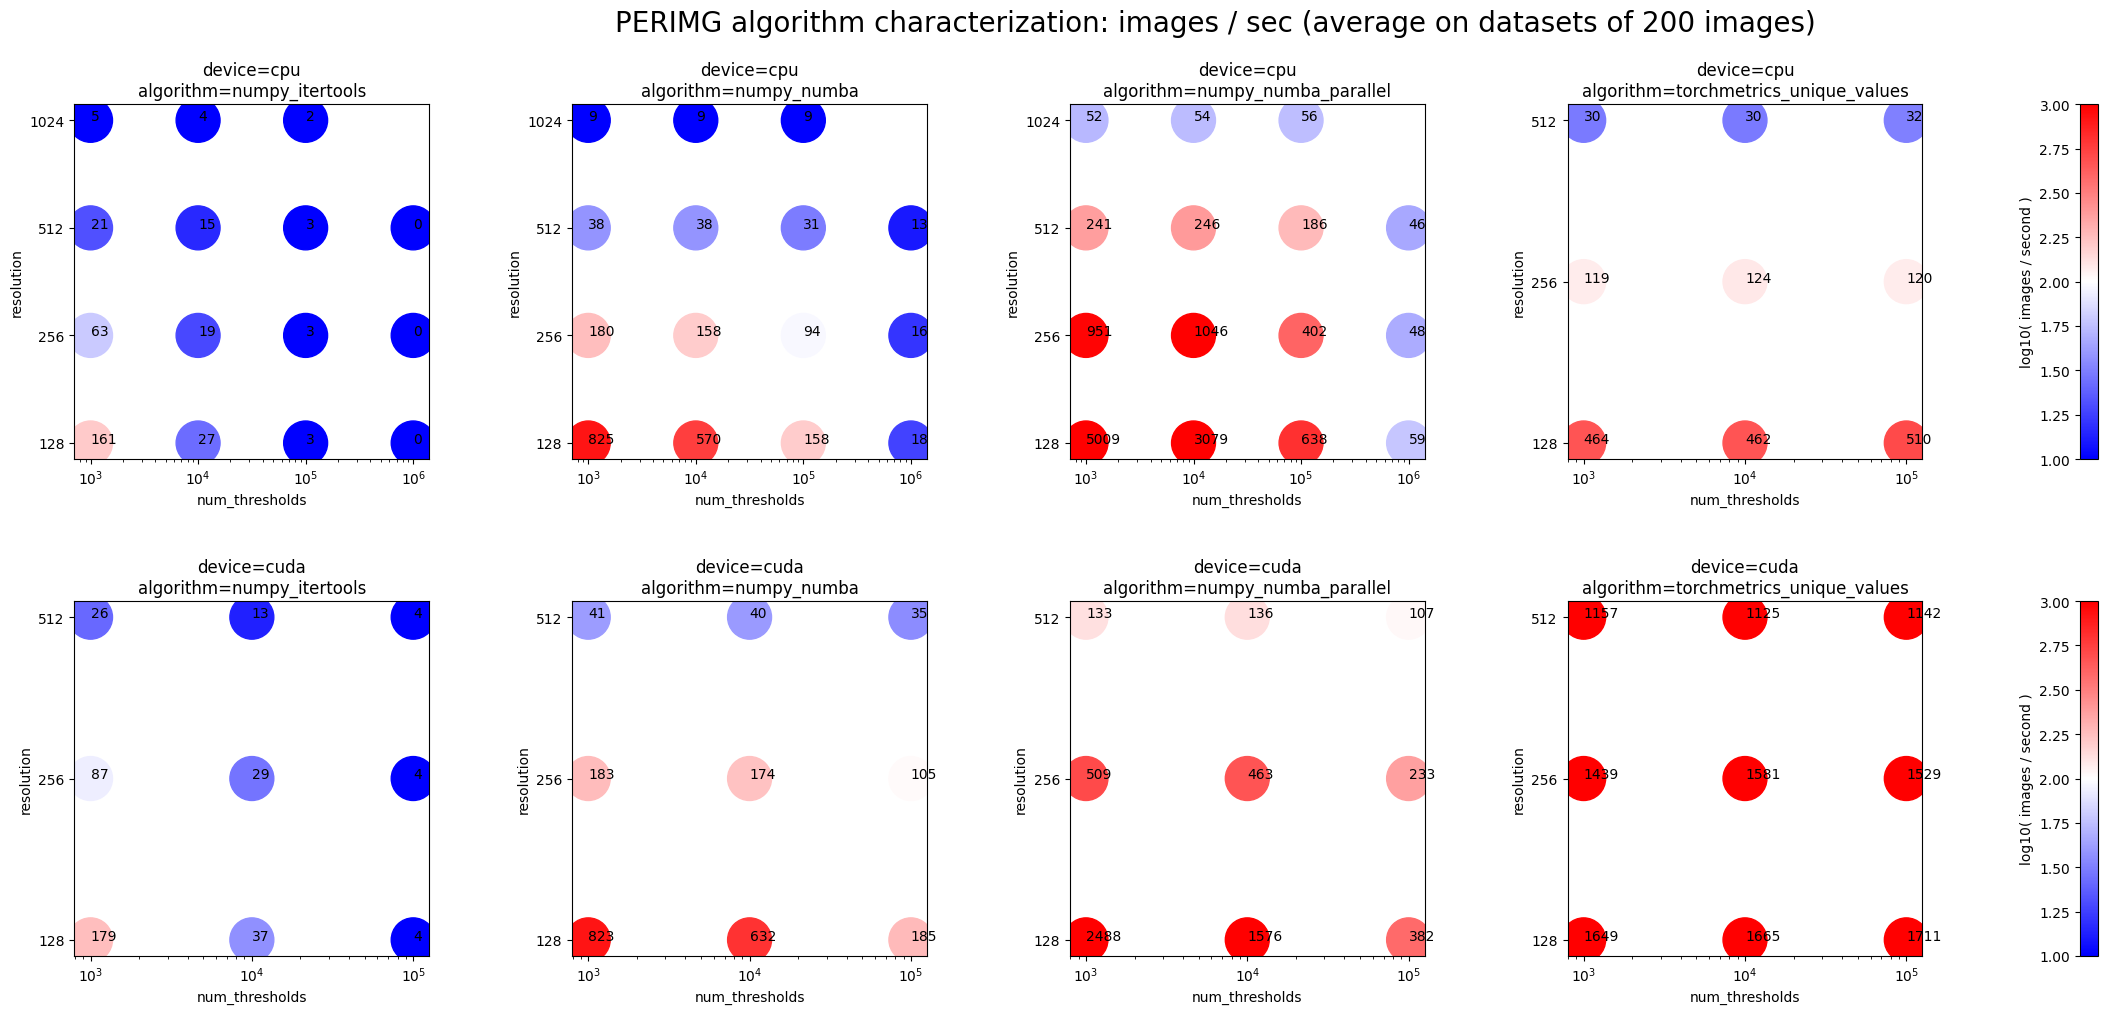

In [26]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

PLOTGRID_ROW_COLS = ["device"]
PLOTGRID_COL_COLS = ["algorithm"]
LINE_COLS = []
# "device"

dfplot = df_perimg.query("num_images in (200,) and algorithm in ('numpy_numba', 'numpy_numba_parallel', 'numpy_itertools', 'torchmetrics_unique_values' )")

# `pg` stands for `plotgrid`
pg_row_dfidxs = dfplot.groupby(PLOTGRID_ROW_COLS).size().index.tolist() if len(PLOTGRID_ROW_COLS) > 0 else [None]
pg_col_dfidxs = dfplot.groupby(PLOTGRID_COL_COLS).size().index.tolist() if len(PLOTGRID_COL_COLS) > 0 else [None]

fig, axes = plt.subplots(nr := len(pg_row_dfidxs), nc := len(pg_col_dfidxs) + 1, figsize=(nc * (sz := 5), nr * sz))  # CUSTOM
axes = (axes if nr*nc > 1 else np.array(axes) ).reshape(nr, nc) 

# `gidx` stands for `group index` , `gdf` stands for `group dataframe`
for pgrow_gidx, pgrow_gdf in dfplot.groupby(PLOTGRID_ROW_COLS) if len(PLOTGRID_ROW_COLS) > 0 else [((None,), dfplot)]:
    for pgcol_gidx, pgcol_gdf in pgrow_gdf.groupby(PLOTGRID_COL_COLS) if len(PLOTGRID_COL_COLS) > 0 else [((None,), pgrow_gdf)]:
        if len(pgcol_gdf) == 0: continue
        
        # convert dataframe index (tuple[any]) into int index of the plotgrid rows and columns 
        # it has to be converted like this because some `pgrow_df` may not have all the column groups
        # `ridx`/`cidx` stands for `row-index`/`col-index`
        pg_ridx = pg_row_dfidxs.index(pgrow_gidx[0] if len(pgrow_gidx) == 1 else pgrow_gidx)  
        pg_cidx = pg_col_dfidxs.index(pgcol_gidx[0] if len(pgcol_gidx) == 1 else pgcol_gidx)  
        ax = axes[pg_ridx, pg_cidx]
        
        # `rname`/`cname` stands for `row-name`/`col-name`
        pg_rname = ", ".join(map("=".join, zip(PLOTGRID_ROW_COLS, map(str, pgrow_gidx)))) if pgrow_gidx[0] is not None else ""
        pg_cname = ", ".join(map("=".join, zip(PLOTGRID_COL_COLS, map(str, pgcol_gidx)))) if pgcol_gidx[0] is not None else ""
        _ = ax.set_title(f"{pg_rname}\n{pg_cname}".strip())
        
        for line_gidx, line_gdf in pgcol_gdf.groupby(LINE_COLS) if len(LINE_COLS) > 0 else [((None,), pgcol_gdf)]:
            if len(line_gdf) == 0: continue
            
            # `lname` stands for `line-name`
            pg_lname = ", ".join(map("=".join, zip(LINE_COLS, map(str, line_gidx)))) if line_gidx is not None else ""

            # ------------------------------------------------------------
            
            data = line_gdf.groupby(["resolution", "num_thresholds"]).describe()["imgs_persec"][["mean"]].reset_index()
            xs = data["num_thresholds"]
            ys = data["resolution"]
            zs = np.log10(data["mean"])
            handle = ax.scatter(
                x=xs, y=ys, c=zs,
                marker="o", vmin=1, vmax=3, s=1000, cmap="bwr",
                label="log10(images / second)",
            )
            for x, y, z in zip(xs, ys, zs): _ = ax.annotate(f"{10**z:.0f}", (x, y))
                            
        _ = ax.set_aspect("equal")
        _ = ax.set_xscale("log")
        _ = ax.set_yscale("log", base=2)
        _ = ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
        _ = ax.set_xlabel("num_thresholds")
        _ = ax.set_ylabel("resolution")

    _ = fig.colorbar(handle, ax=axes[pg_ridx, -1], label="log10( images / second )", orientation="vertical", location="left")

# ------------------------------------------------------------
lims = np.array([[ax.get_xlim(), ax.get_ylim()] for ax in axes.flatten()]).reshape(axes.shape + (2, 2))
pgrows_lims = np.stack([lims[..., 0].min(axis=1), lims[..., 1].max(axis=1)], axis=-1)
pgcols_lims = np.stack([lims[..., 0].min(axis=0), lims[..., 1].max(axis=0)], axis=-1)

# grid-row: same y-axis limits
# for ax, (ridx, cidx) in zip(axes.flatten(), np.ndindex(axes.shape)): _ = ax.set_ylim(pgrows_lims[ridx][1])
# grid-col: same x-axis limits
# for ax, (ridx, cidx) in zip(axes.flatten(), np.ndindex(axes.shape)): _ = ax.set_xlim(pgcols_lims[cidx][0])

# turn off axes for subplots that are empty    
for ax in [ax for ax in axes.flatten() if not ax.get_title()]: _ = ax.set_visible(False)

_ = fig.suptitle("PERIMG algorithm characterization: images / sec (average on datasets of 200 images)", fontsize=20, y=1.002)
_ = fig.tight_layout(h_pad=0, w_pad=0)
_ = fig.subplots_adjust(hspace=0.4, wspace=0.2)

# experiment 2 (set): all algorithms

On each plot:
    - x-axis: `num_thrsholds`
    - y-axis: `thousand_samples_persec`
    - each line is a different (`algorithm`, `device`)
    - `device == 'cuda'` is in dashed line

Subplots:
    - column: `resolution`
    - row: `num_images`

In [32]:
df_set

,resolution,num_images,num_thresholds,seed,algorithm,device,hostname,num_cpus,seconds,num_samples,thousand_samples,thousand_samples_persec
0,128,100,100000,0,numpy_itertools,cpu,node043,32,0.65877,1638400,1638.4,3.12129e+01
1,128,100,100000,0,numpy_itertools,cpu,node043,32,0.65452,1638400,1638.4,3.11049e+01
2,128,100,100000,0,numpy_itertools,cpu,node043,32,0.65242,1638400,1638.4,3.11258e+01
3,128,100,100000,0,numpy_itertools,cpu,node043,32,0.65201,1638400,1638.4,3.10969e+01
4,128,100,100000,0,numpy_itertools,cpu,node043,32,0.65534,1638400,1638.4,3.02343e+01
...,...,...,...,...,...,...,...,...,...,...,...,...
2125,512,100,1000,4,torchmetrics_unique_values,cuda,node062,28,0.03793,26214400,26214.4,1.14172e+06
2126,512,100,1000,4,torchmetrics_unique_values,cuda,node062,28,0.03136,26214400,26214.4,2.14706e+06
2127,512,100,1000,4,torchmetrics_unique_values,cuda,node062,28,0.03124,26214400,26214.4,2.16087e+06
2128,512,100,1000,4,torchmetrics_unique_values,cuda,node062,28,0.03071,26214400,26214.4,2.16152e+06


/tmp/ipykernel_631819/2245194339.py:67: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  for ax, (ridx, cidx) in zip(axes.flatten(), np.ndindex(axes.shape)): _ = ax.set_ylim(pgrows_lims[ridx][1])


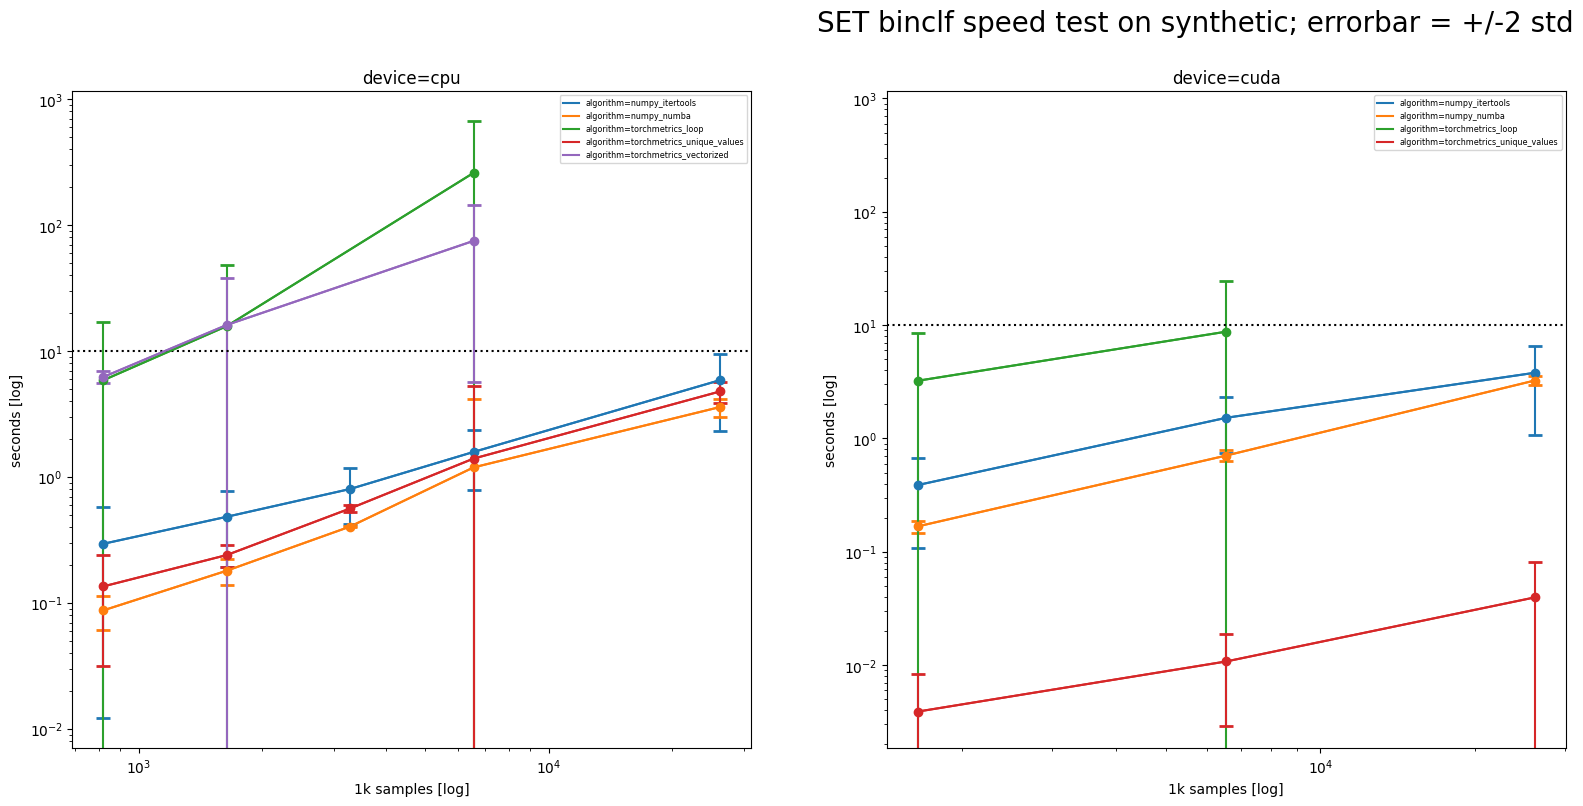

In [45]:
import numpy as np
from matplotlib import pyplot as plt

PLOTGRID_ROW_COLS = []
PLOTGRID_COL_COLS = ["device"]
LINE_COLS = ["algorithm",]

dfplot = df_set

# `pg` stands for `plotgrid`
pg_row_dfidxs = dfplot.groupby(PLOTGRID_ROW_COLS).size().index.tolist() if len(PLOTGRID_ROW_COLS) > 0 else [None]
pg_col_dfidxs = dfplot.groupby(PLOTGRID_COL_COLS).size().index.tolist() if len(PLOTGRID_COL_COLS) > 0 else [None]

fig, axes = plt.subplots(nr := len(pg_row_dfidxs), nc := len(pg_col_dfidxs) + 1, figsize=(nc * (sz := 8), nr * sz))
axes = (axes if nr*nc > 1 else np.array(axes) ).reshape(nr, nc) 

# `gidx` stands for `group index` , `gdf` stands for `group dataframe`
for pgrow_gidx, pgrow_gdf in dfplot.groupby(PLOTGRID_ROW_COLS) if len(PLOTGRID_ROW_COLS) > 0 else [((None,), dfplot)]:
    for pgcol_gidx, pgcol_gdf in pgrow_gdf.groupby(PLOTGRID_COL_COLS) if len(PLOTGRID_COL_COLS) > 0 else [((None,), pgrow_gdf)]:
        if len(pgcol_gdf) == 0: continue
        
        # convert dataframe index (tuple[any]) into int index of the plotgrid rows and columns 
        # it has to be converted like this because some `pgrow_df` may not have all the column groups
        # `ridx`/`cidx` stands for `row-index`/`col-index`
        pg_ridx = pg_row_dfidxs.index(pgrow_gidx[0] if len(pgrow_gidx) == 1 else pgrow_gidx)  
        pg_cidx = pg_col_dfidxs.index(pgcol_gidx[0] if len(pgcol_gidx) == 1 else pgcol_gidx)  
        ax = axes[pg_ridx, pg_cidx]
        
        # `rname`/`cname` stands for `row-name`/`col-name`
        pg_rname = ", ".join(map("=".join, zip(PLOTGRID_ROW_COLS, map(str, pgrow_gidx)))) if pgrow_gidx[0] is not None else ""
        pg_cname = ", ".join(map("=".join, zip(PLOTGRID_COL_COLS, map(str, pgcol_gidx)))) if pgcol_gidx[0] is not None else ""
        _ = ax.set_title(f"{pg_rname}\n{pg_cname}".strip())
        
        for line_gidx, line_gdf in pgcol_gdf.groupby(LINE_COLS) if len(LINE_COLS) > 0 else [((None,), pgcol_gdf)]:
            if len(line_gdf) == 0: continue
            
            # `lname` stands for `line-name`
            pg_lname = ", ".join(map("=".join, zip(LINE_COLS, map(str, line_gidx)))) if line_gidx is not None else ""

            # ------------------------------------------------------------
            # data = line_gdf.groupby("thousand_samples").describe()["thousand_samples_persec"][["mean", "std",]].reset_index()
            data = line_gdf.groupby("thousand_samples").describe()["seconds"][["mean", "std",]].reset_index()
            xs = data["thousand_samples"]
            ys = data["mean"]
            yerr = data["std"] * 2
            line_handle = ax.plot(xs, ys, label=pg_lname, linestyle="-")[0]
            if not np.isnan(yerr).any():
                _ = ax.errorbar(
                    xs, ys, yerr=yerr, 
                    fmt='o', capsize=5, capthick=2, 
                    ecolor=line_handle.get_color(), color=line_handle.get_color(), linestyle=line_handle.get_linestyle()
                )
        
        _ = ax.axhline(10, color='k', linestyle=":")    
        
        _ = ax.set_xscale("log")
        _ = ax.set_yscale("log")
        _ = ax.set_xlabel("1k samples [log]")
        _ = ax.set_ylabel("seconds [log]")
        _ = ax.legend(loc='upper right', fontsize='xx-small')

lims = np.array([[ax.get_xlim(), ax.get_ylim()] for ax in axes.flatten()]).reshape(axes.shape + (2, 2))
pgrows_lims = np.stack([lims[..., 0].min(axis=1), lims[..., 1].max(axis=1)], axis=-1)
pgcols_lims = np.stack([lims[..., 0].min(axis=0), lims[..., 1].max(axis=0)], axis=-1)

# grid-row: same y-axis limits
for ax, (ridx, cidx) in zip(axes.flatten(), np.ndindex(axes.shape)): _ = ax.set_ylim(pgrows_lims[ridx][1])
# grid-col: same x-axis limits
for ax, (ridx, cidx) in zip(axes.flatten(), np.ndindex(axes.shape)): _ = ax.set_xlim(pgcols_lims[cidx][0])

# turn off axes for subplots that are empty    
for ax in [ax for ax in axes.flatten() if not ax.get_title()]: _ = ax.set_visible(False)

_ = fig.suptitle("SET binclf speed test on synthetic; errorbar = +/-2 std", fontsize=20, y=1.002)
_ = fig.tight_layout(h_pad=0, w_pad=0)
_ = fig.subplots_adjust(hspace=0.3, wspace=0.2)

In [42]:
line_gdf

,resolution,num_images,num_thresholds,seed,algorithm,device,hostname,num_cpus,seconds,num_samples,thousand_samples,thousand_samples_persec
40,128,100,100000,0,torchmetrics_unique_values,cuda,node062,28,0.00797,1638400,1638.4,2.50943e+01
41,128,100,100000,0,torchmetrics_unique_values,cuda,node062,28,0.00276,1638400,1638.4,2.46510e+01
42,128,100,100000,0,torchmetrics_unique_values,cuda,node062,28,0.00268,1638400,1638.4,2.46353e+01
43,128,100,100000,0,torchmetrics_unique_values,cuda,node062,28,0.00273,1638400,1638.4,2.46895e+01
44,128,100,100000,0,torchmetrics_unique_values,cuda,node062,28,0.00267,1638400,1638.4,2.46228e+01
...,...,...,...,...,...,...,...,...,...,...,...,...
2125,512,100,1000,4,torchmetrics_unique_values,cuda,node062,28,0.03793,26214400,26214.4,1.14172e+06
2126,512,100,1000,4,torchmetrics_unique_values,cuda,node062,28,0.03136,26214400,26214.4,2.14706e+06
2127,512,100,1000,4,torchmetrics_unique_values,cuda,node062,28,0.03124,26214400,26214.4,2.16087e+06
2128,512,100,1000,4,torchmetrics_unique_values,cuda,node062,28,0.03071,26214400,26214.4,2.16152e+06
